In [10]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils
from torch import nn
from torch import optim
import torchvision.transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Loading MNIST (training only, as we do unsupervised learning with autoencoders)

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
    ])
)

# Creating a dataloader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [51]:
nz = 30 # number of latent variables
nf = 64
lr = 1e-3
num_epochs = 10

In [47]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nf, 5, 1, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.Conv2d(nf, nf, 5, 1, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.Conv2d(nf, nf * 2, 5, 2, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 2),
            # 128 x 16 x 16
            nn.Conv2d(nf * 2, nf * 4, 5, 2, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 4),
            # 256 x 8 x 8
            nn.Conv2d(nf * 4, nf * 8, 5, 2, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 8),
            # 512 x 4 x 4
            nn.Conv2d(nf * 8, nz, 4, 1, 0, bias=False),
            # nz x 1 x 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(nz, nf * 8, 4, 1, 0, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 8),
            # 512 x 4 x 4
            nn.ConvTranspose2d(nf * 8, nf * 4, 5, 2, 2, bias=False, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 4),
            # 256 x 8 x 8
            nn.ConvTranspose2d(nf * 4, nf * 2, 5, 2, 2, bias=False, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 2),
            # 128 x 16 x 16
            nn.ConvTranspose2d(nf * 2, nf, 5, 2, 2, bias=False, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.ConvTranspose2d(nf, nf, 5, 1, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.ConvTranspose2d(nf, 1, 5, 1, 2, bias=False),
            nn.Sigmoid()
            # 1 x 32 x 32
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [77]:
## a much smaller AE, quicker to train

# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = torch.nn.Sequential(
#             nn.Conv2d(1, 16, 3, padding=1), # 28 x 28 x 1 ==> 28 x 28 x 16
#             nn.ReLU(),
#             nn.Conv2d(16, 16, 3, padding=1), # 28 x 28 x 16 ==> 28 x 28 x 16
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, padding=1, stride=2), # 28 x 28 x 16 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, padding=1), # 14 x 14 x 32 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 3, padding=1, stride=2), # 14 x 14 x 32 ==> 7 x 7 x 64
#             nn.ReLU(),
#             nn.Conv2d(64, 64, 3, padding=1), # 7 x 7 x 64 ==> 7 x 7 x 64
#             nn.ReLU(),
#             nn.Flatten(start_dim=1), # 7 x 7 x 64 ==> 64 * 7 * 7
#             nn.Linear(64 * 7 * 7, 200), # 64 * 7 * 7 ==> 200
#             nn.ReLU(),
#             nn.Linear(200, 50),
#             nn.ReLU()
#         )
         
#         self.decoder = torch.nn.Sequential(
#             nn.Linear(50, 200), # 50 ==> 200
#             nn.ReLU(),
#             nn.Linear(200, 64 * 7 * 7), # 200 ==> 64 * 7 * 7
#             nn.ReLU(),
#             nn.Unflatten(1, (64, 7, 7)), # 64 * 7 * 7 ==> 7 x 7 x 64
#             nn.ConvTranspose2d(64, 64, 3, padding=1), # 7 x 7 x 64 ==> 7 x 7 x 64
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1), # 7 x 7 x 64 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 32, 3, padding=1), # 14 x 14 x 32 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, padding=1, stride=2, output_padding=1), # 14 x 14 x 32 ==> 28 x 28 x 16
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, padding=1),
#             nn.Sigmoid(),
#         )
 
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [52]:
model = AutoEncoder().to(device)
# loss_fn will be BCELoss
# loss_fn = nn.MSELoss(reduction='sum')
loss_fn = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(params=model.parameters(), lr=lr, betas=(0.5, 0.999))

In [53]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0

    for batch, (X, _) in enumerate(train_loader):
        X = X.to(device)

        # forward pass
        output = model(X)
        loss = loss_fn(output, X)
        total_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # printing the loss
    print("Epoch: {}, Loss: {}".format(epoch+1, total_loss / (batch + 1)))

Epoch: 1, Loss: 11486.066526758645
Epoch: 2, Loss: 7081.286039112473
Epoch: 3, Loss: 6845.369984966352
Epoch: 4, Loss: 6757.024714423141
Epoch: 5, Loss: 6706.657937901869
Epoch: 6, Loss: 6675.150911180704
Epoch: 7, Loss: 6641.563358396355
Epoch: 8, Loss: 6620.0288869373835
Epoch: 9, Loss: 6594.072362448361
Epoch: 10, Loss: 6575.304080011494


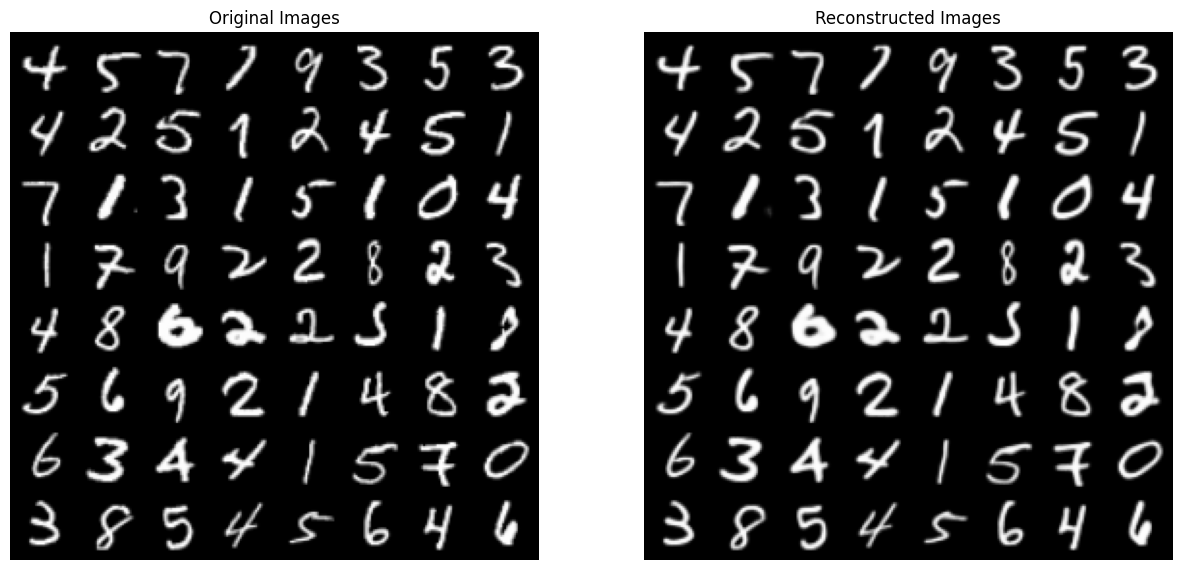

In [81]:
sample_data = next(iter(train_loader))[0].to(device)
sample_output = model(sample_data)

img_grid = torchvision.utils.make_grid(sample_output.detach().cpu(), nrow=8)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(sample_data.detach().cpu(), nrow=8), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Reconstructed Images')
plt.imshow(np.transpose(img_grid, (1, 2, 0)))
plt.show()